In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from skimage import exposure
from geophys_utils import NetCDFGridUtils
from geophys_utils import NetCDFLineUtils
from geophys_utils import get_gdal_wcs_dataset, get_gdal_grid_values
from geophys_utils import get_spatial_ref_from_wkt, get_coordinate_transformation, get_utm_wkt, transform_coords
from geophys_utils._transect_utils import line_length, point_along_line, utm_coords, coords2distance, sample_transect

In [3]:
######   AEM links will be updated when available ######
aem_nc_path = "D:\\Temp\\AEM Data\\AusAEM_Year1_Tranche1_Final_CND.nc"
if not os.path.isfile(aem_nc_path):
    aem_nc_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/axi547/aem/AusAEM_Year1_Tranche1_Final_CND.nc'

In [4]:
aem_nc_dataset = netCDF4.Dataset(aem_nc_path + '#fillmismatch') # Note work-around for bad _FillValue: https://github.com/Unidata/netcdf-c/issues/1299

In [5]:
netcdf_line_utils = NetCDFLineUtils(aem_nc_dataset)

In [6]:
netcdf_line_utils.line[:]

masked_array(data=[1010001, 1010002, 1010003, 1010004, 1020001, 1020002,
                   1020003, 1030001, 1030002, 1030003, 1030004, 1040001,
                   1040002, 1050001, 1050002, 1050003, 1060001, 1060002,
                   1060003, 1070001, 1070002, 1080001, 1080002, 1090001,
                   1090002, 1100001, 1100002, 1110001, 1110002, 1110003,
                   1120001, 1120002, 1130001, 1130002, 1140001, 1140002,
                   1140003, 1150001, 1150002, 1150003, 1150004, 1160001,
                   1160002, 1170001, 1170002, 1180001, 1190001, 1200001,
                   1200002, 1210001, 1220001, 1220002, 1230001, 1230002,
                   1240001, 1240002, 1250001, 1250002],
             mask=False,
       fill_value=999999)

In [7]:
line_no = 1090002 
line_no, line_mask = next(netcdf_line_utils.get_line_masks(1090002))
np.count_nonzero(line_mask)

35648

In [8]:
# Create array of UTM coordinate pairs for all points in selected line
utm_wkt, full_utm_coords = netcdf_line_utils.utm_coords(netcdf_line_utils.xycoords)
utm_coordinates = full_utm_coords[line_mask]

In [9]:
# Compute cumulative distance along line for each point
distances = coords2distance(utm_coordinates)
distances

array([0.00000000e+00, 1.11892111e+01, 2.23784221e+01, ...,
       4.14326142e+05, 4.14339718e+05, 4.14352165e+05])

In [10]:
# Obtain top elevation for each layer at each point
layer_top_elevations = np.repeat(aem_nc_dataset.variables['dtm'][line_mask][:, np.newaxis], 
                                 aem_nc_dataset.variables['cond_xz_depth'].shape[1], 
                                 axis=1) + aem_nc_dataset.variables['cond_xz_depth'][line_mask]
layer_top_elevations

masked_array(
  data=[[ 268.2    ,  263.2    ,  258.2    , ..., -216.79999, -221.79999,
         -226.79999],
        [ 268.15   ,  263.15   ,  258.15   , ..., -216.85   , -221.85   ,
         -226.85   ],
        [ 268.09   ,  263.09   ,  258.09   , ..., -216.91   , -221.91   ,
         -226.91   ],
        ...,
        [ 195.68   ,  190.68   ,  185.68   , ..., -289.32   , -294.32   ,
         -299.32   ],
        [ 195.39   ,  190.39   ,  185.39   , ..., -289.61   , -294.61   ,
         -299.61   ],
        [ 195.09   ,  190.09   ,  185.09   , ..., -289.91   , -294.91   ,
         -299.91   ]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [11]:
# Obtain conductivity for each layer at each point
layer_conductivities = aem_nc_dataset.variables['cond_xz'][line_mask]
layer_conductivities

masked_array(
  data=[[1.0000e-02, 1.0000e-02, 6.6440e+00, ..., 2.1656e+01, 3.9098e+01,
         1.1995e+01],
        [1.0000e-02, 1.0000e-02, 6.6440e+00, ..., 3.9098e+01, 2.1656e+01,
         1.1995e+01],
        [1.0000e-02, 1.0000e-02, 6.6440e+00, ..., 2.1656e+01, 2.1656e+01,
         6.6440e+00],
        ...,
        [1.0000e-02, 1.0000e-02, 6.6440e+00, ..., 6.6440e+00, 3.6800e+00,
         3.6800e+00],
        [1.0000e-02, 1.0000e-02, 6.6440e+00, ..., 6.6440e+00, 1.1995e+01,
         1.1290e+00],
        [1.0000e-02, 1.0000e-02, 6.6440e+00, ..., 2.1656e+01, 1.1995e+01,
         6.6440e+00]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [12]:
# Number of subdivisions for each layer for interpolation. 
# Note that transition between adjacent layer values will occur in lowest subdivision of uppermost layer
layer_subdivisions = 2

In [13]:
# Complete elevation array for layer samples indexed by point and layer
sublayer_elevations = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                          dtype=layer_top_elevations.dtype) * np.NaN

In [14]:
# Complete conductivity array for layer samples indexed by point and layer
sublayer_conductivities = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                                  dtype=layer_conductivities.dtype) * np.NaN

In [15]:
# Array of maximum elevations for each point
max_elevation = np.nanmax(layer_top_elevations, axis=1)

In [16]:
# Array of minimum elevations for each point
min_elevation = np.ones(shape=(layer_top_elevations.shape[0],), 
                        dtype=layer_top_elevations.dtype) * np.NaN

In [17]:
# Sub-sample layers for later interpolation. Remember minimum valid elevation for each point
for point_index in range(layer_top_elevations.shape[0]):
    for layer_index in range(layer_top_elevations.shape[1]):
        try:
            layer_thickness = layer_top_elevations[point_index, layer_index] - layer_top_elevations[point_index, layer_index + 1]
        except:
            break
            
        if np.isnan(layer_conductivities[point_index, layer_index]):
            break
            
        #print(layer_top_elevations[point_index, layer_index], layer_thickness, layer_conductivities[point_index, layer_index])
        min_elevation[point_index] = layer_top_elevations[point_index, layer_index + 1]
        
        for sublayer_index in range(layer_subdivisions):
            sublayer_elevations[point_index, layer_index*layer_subdivisions+sublayer_index] = layer_top_elevations[point_index, layer_index] - sublayer_index * layer_thickness / layer_subdivisions 
            sublayer_conductivities[point_index, layer_index*layer_subdivisions+sublayer_index] = layer_conductivities[point_index, layer_index]

In [18]:
# Display max/min elevation values
print(np.nanmax(min_elevation))
print(np.nanmin(min_elevation))
min_elevation

-124.45999
-304.53


array([-226.79999, -226.85   , -226.91   , ..., -299.32   , -299.61   ,
       -299.91   ], dtype=float32)

In [19]:
# Create complete 2D grid of sub-layer point distances for every point/layer - needed for interpolation
point_distances = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                                  dtype=layer_top_elevations.dtype) * np.NaN
for depth_index in range(point_distances.shape[1]):
    point_distances[:,depth_index] = distances
#point_distances

In [20]:
# Obtain good data mask to discard invalid layer samples
good_data_mask = np.logical_and(~np.isnan(sublayer_elevations), ~np.isnan(sublayer_conductivities))
#good_data_mask

In [21]:
# Discard invalid points and store distance/elevation coordinates in dense 2D array
point_distance_elevation = np.ones(shape=(np.count_nonzero(good_data_mask), 2), 
                                  dtype=layer_top_elevations.dtype) * np.NaN
point_distance_elevation[:,0] = point_distances[good_data_mask]
point_distance_elevation[:,1] = sublayer_elevations[good_data_mask]
point_distance_elevation.shape

(7058304, 2)

In [22]:
# Discard invalid conductivity points
point_conductivity = sublayer_conductivities[good_data_mask]
point_conductivity

array([1.0000e-02, 1.0000e-02, 1.0000e-02, ..., 2.1656e+01, 1.1995e+01,
       1.1995e+01], dtype=float32)

In [23]:
# Compute distance range for bitmap
distance_range = (math.floor(min(point_distance_elevation[:,0]) / 10.0) * 10.0, 
                   math.ceil(max(point_distance_elevation[:,0]) / 10.0) * 10.0)
distance_range

(0.0, 414360.0)

In [24]:
# Compute elevation range for bitmap
elevation_range = (math.floor(min(point_distance_elevation[:,1]) / 10.0) * 10.0, 
                   math.ceil(max(point_distance_elevation[:,1]) / 10.0) * 10.0)
elevation_range

(-310.0, 380.0)

In [25]:
# Compute regular grid for resampling
resampling_method = 'linear'

xres = 100.0 # 10m/pixel horizontally
yres = 1.0 # 1m/pixel vertically

grid_y, grid_x = np.mgrid[elevation_range[1]:elevation_range[0]:-yres, 
                          distance_range[0]:distance_range[1]:xres]
#print(grid_y, grid_x)

In [26]:
# Compute interpolated 1D array of maximum valid elevation values for each X
max_elevation_grid = griddata(point_distances[:,0],
                              max_elevation,
                              grid_x[0], 
                              method=resampling_method)
max_elevation_grid

array([268.20001221, 267.85302263, 267.89001465, ..., 199.09020076,
       197.62381296, 196.12231847])

In [27]:
# Compute interpolated 1D array of minimum valid elevation values for each X
min_elevation_grid = griddata(point_distances[:,0],
                              min_elevation,
                              grid_x[0], 
                              method=resampling_method)
min_elevation_grid

array([-226.79998779, -227.14697737, -227.10998535, ..., -295.90980599,
       -297.37619034, -298.87768153])

In [28]:
# Resample point-wise conductivity into regular grid for bitmap
conductivity_grid = griddata(point_distance_elevation[:,::-1],
         point_conductivity,
         (grid_y, grid_x), 
         method=resampling_method)
conductivity_grid.shape

(690, 4144)

In [29]:
# Purge interpolated values for all elevations < minimum valid elevation
bad_data_mask = np.logical_or(grid_y < np.repeat(min_elevation_grid[np.newaxis, :], 
                                      grid_y.shape[0], 
                                      axis=0),
                              grid_y > np.repeat(max_elevation_grid[np.newaxis, :], 
                                                 grid_y.shape[0], 
                                                 axis=0)
                              )

conductivity_grid[bad_data_mask] = np.NaN

In [30]:
# Availabole cmap values for imshow:
# Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gi

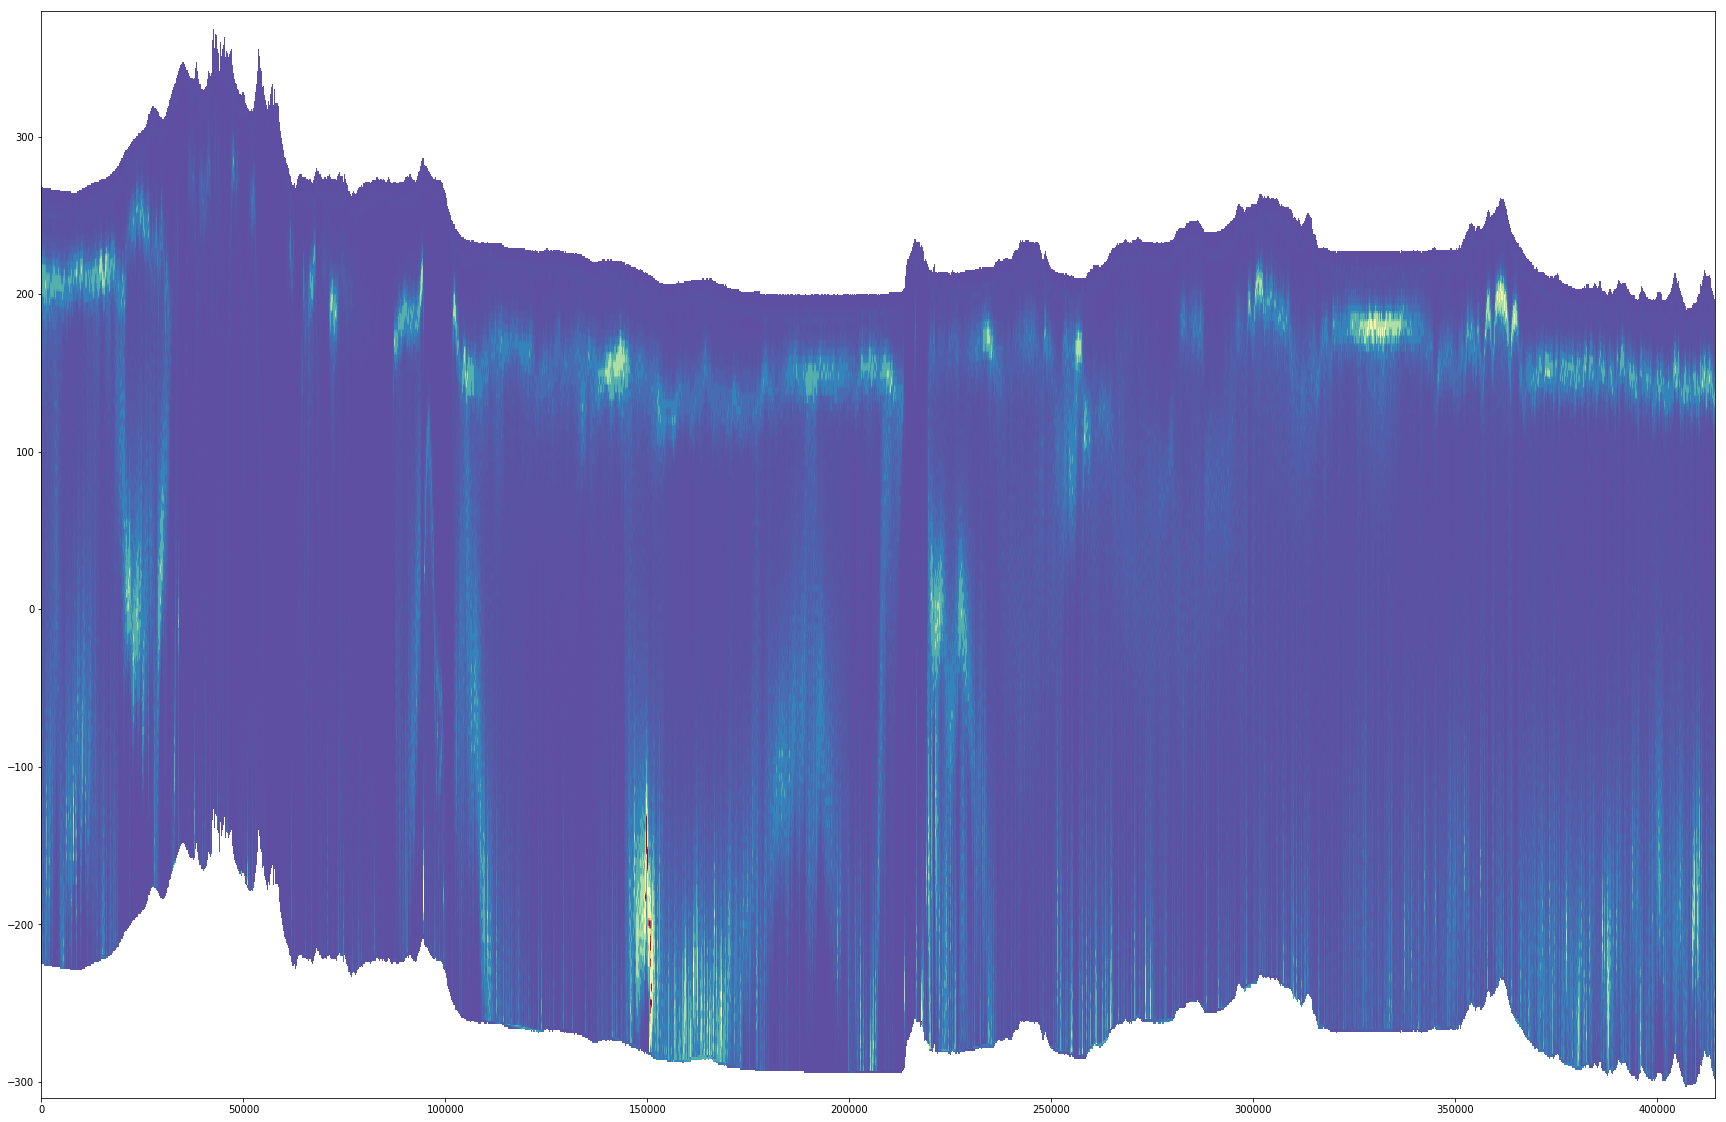

In [31]:
# Plot linear colour stretch
plt.figure(figsize=(30,20))    
plt.imshow(conductivity_grid, 
           extent=(distance_range[0], distance_range[1], elevation_range[0], elevation_range[1]),
           aspect='auto',
           cmap='Spectral_r')

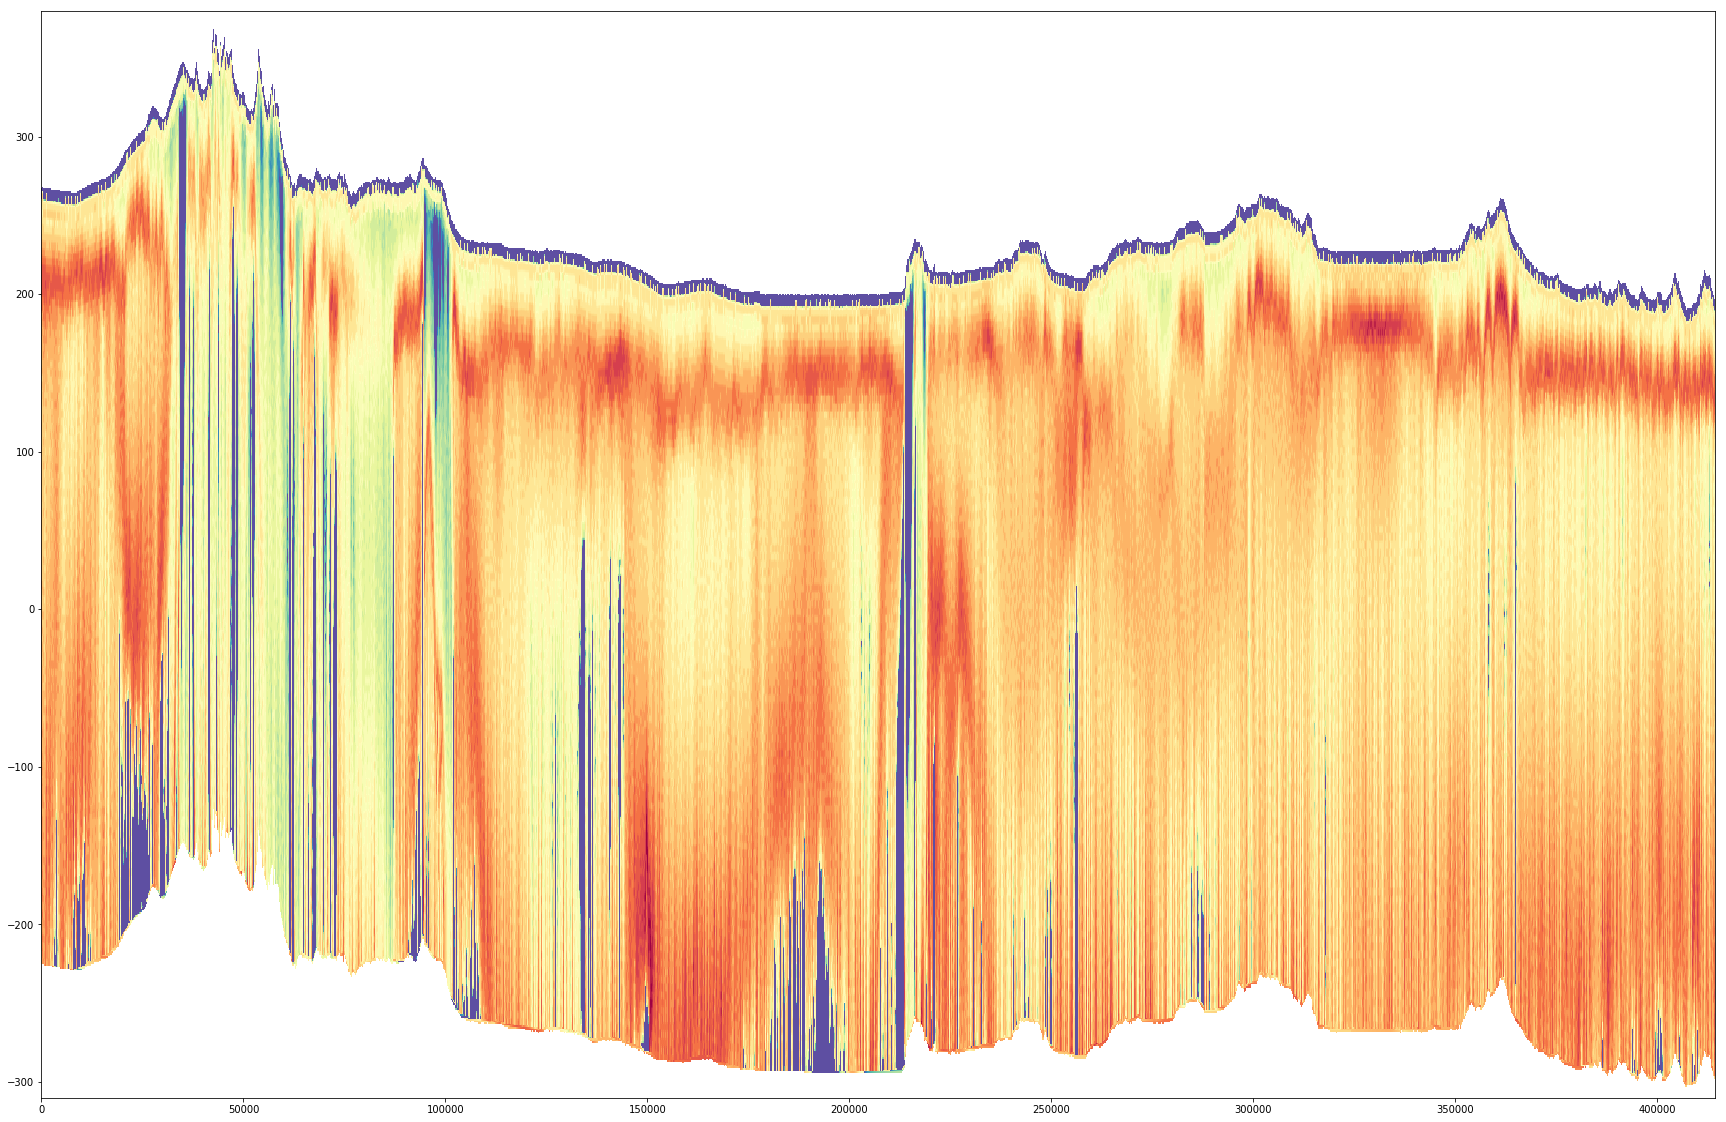

In [32]:
# Plot logarithmic colour stretch (linear stretch on log values)
plt.figure(figsize=(30,20))    
plt.imshow(np.log(conductivity_grid), 
           extent=(distance_range[0], distance_range[1], elevation_range[0], elevation_range[1]),
           aspect='auto',
           cmap='Spectral_r')

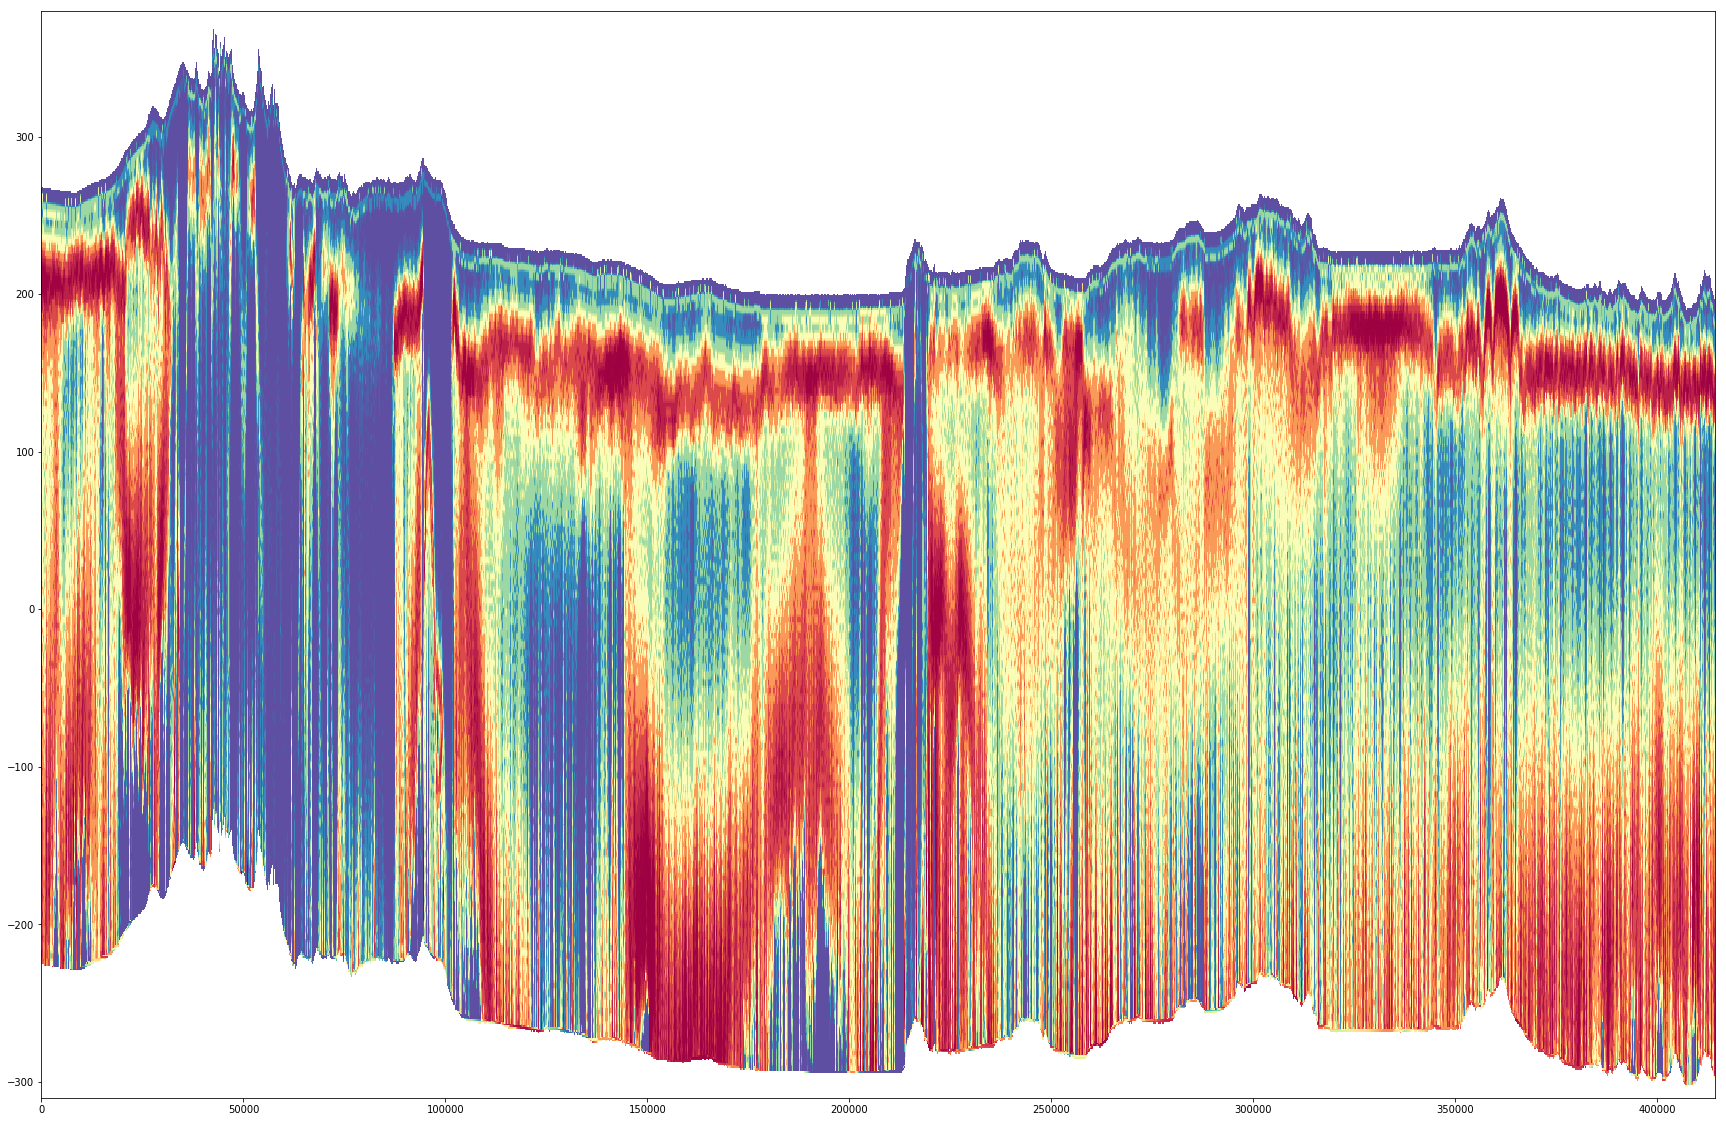

In [33]:
# Plot histogram equalised colour stretch
# Substitute minimum value for NaN values to allow histogram equalisation to work
def histogram_equalise(data_array, fill_value):
    filled_grid = np.array(data_array)
    filled_grid[np.isnan(filled_grid)] = np.nanmin(filled_grid)
    histogram_grid = exposure.equalize_hist(filled_grid)
    histogram_grid[np.isnan(data_array)] = np.NaN
    return histogram_grid


plt.figure(figsize=(30,20))    
plt.imshow(histogram_equalise(conductivity_grid, np.nanmin(conductivity_grid)), 
           extent=(distance_range[0], distance_range[1], elevation_range[0], elevation_range[1]),
           aspect='auto',
           cmap='Spectral_r')